In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Morning Session 6: Conditional Generative Adversarial Networks (cGANs)

Conditional GANs enables the generation of realistic data that matches the given labels -- greatly improves the value of GANs in real practises.

![](https://miro.medium.com/max/700/1*Vjo1df-yPFks2e_-TbdWdQ.png)

Image credit: [medium blog](https://medium.com/@ma.bagheri/a-tutorial-on-conditional-generative-adversarial-nets-keras-implementation-694dcafa6282)




In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Train a conditional GAN
**How to put label into the network?**
* **Simply input it into the networks togather with the latent vector / data**


Latent vector length: 100 Length of the label vector: 10

Network G:

0. Concatenate the z and z_label here using torch.cat()
1. Layer 1 for the latent vector: 110 -> 256
2. Layer 2 for the label vector: 256 -> 512
3. Layer 2: 512 -> 1024
4. Layer 4: 1024 -> 784 (size of a MNIST image) 

Apply leaky_relu(alpha=0.2) activation functions for layers 1-3, and tanh to layer 4.

Network D:

0. Concatenate the z and z_label here using torch.cat()
1. Layer 1: 794 -> 1024
2. Layer 2: 1024 -> 512
3. Layer 3: 512 -> 256
4. Layer 4: 256 -> 1

Apply leaky_relu(alpha=0.2) activation functions and dropout for layers 1-3, and sigmoid to layer 4.



In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_input_dim_label=10, g_output_dim=28*28):
        super().__init__()       
        self.fc1 = nn.Linear(g_input_dim + g_input_dim_label, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x, x_label): 
        x = torch.cat([x, x_label], 1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28, d_label_input_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim+d_label_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x, x_label):
        x = torch.cat([x, x_label], 1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    

# build model
G = Generator().to(device)
D = Discriminator().to(device)

In [5]:
# define loss
criterion = nn.BCELoss() 
z_dim = 100
bs = 100


# optimizer
lr = 0.0001 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [6]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def D_train(x, labs):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (1)
    x_label_real = torch.zeros(bs, 10)
    x_label_real.scatter_(1, labs.view(bs, 1), 1)  
    x_real, y_real = x.view(-1, 28*28), torch.ones(bs, 1)
    x_real, x_label_real, y_real = Variable(x_real.to(device)), Variable(x_label_real.to(device)), Variable(y_real.to(device))


    D_output = D(x_real, x_label_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (0)
    # sample vector and produce generator output

    z = Variable(torch.randn(bs, z_dim).to(device))
    z_label = torch.zeros(bs, 10)
    z_label_ind = torch.randint(low=0, high=10, size=(bs, 1))
    z_label.scatter_(1, z_label_ind.view(bs, 1), 1).type(torch.float)
    z_label = Variable(z_label.to(device))

    x_fake, y_fake = G(z, z_label), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake, z_label)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update 
    D_loss.backward()
    D_optimizer.step()

        
    return  D_loss.data.item()


In [8]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()


    # sample vector and produce generator output
    z = Variable(torch.randn(bs, z_dim).to(device))
    z_label = torch.zeros(bs, 10)
    z_label_ind = torch.randint(low=0, high=10, size=(bs, 1))
    z_label.scatter_(1, z_label_ind.view(bs, 1), 1)
    z_label = Variable(z_label.to(device))

    G_output = G(z, z_label)

    # obtain scores from D for the generated data
    D_output = D(G_output, z_label)

    # train generator to "fool" discriminator
    y = Variable(torch.ones(bs, 1).to(device))
    G_loss = criterion(D_output, y)

    # model update 
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

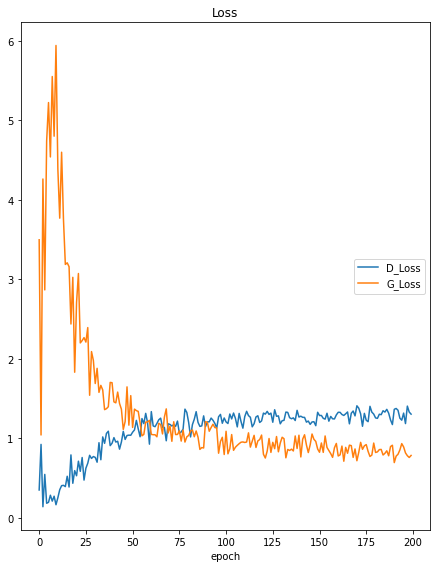

Loss
	D_Loss           	 (min:    0.138, max:    1.409, cur:    1.304)
	G_Loss           	 (min:    0.694, max:    5.944, cur:    0.784)


In [9]:
n_epoch = 200 # about 40 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):  
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, labs) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x, labs)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

Text(0.5, 1.0, 'Epoch = 200')

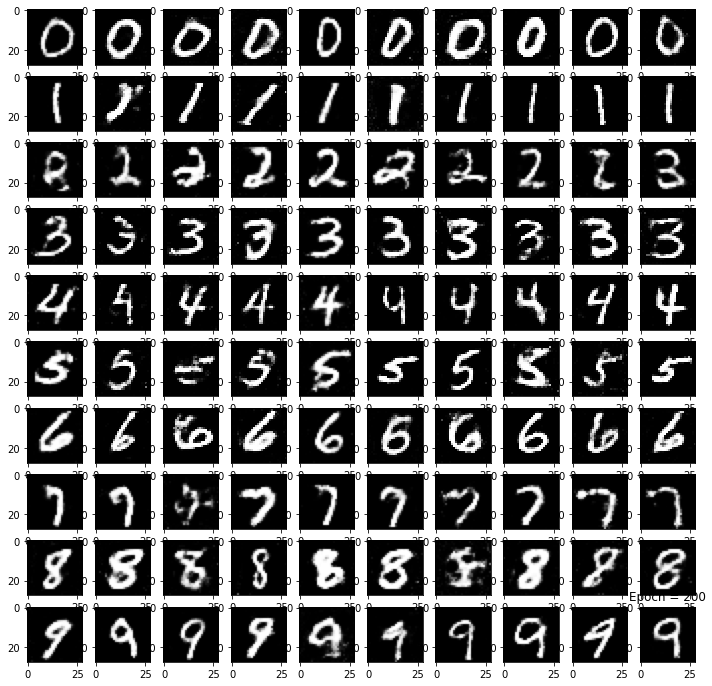

In [10]:
epoch = 200
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = Variable(torch.randn(100, z_dim).to(device))
    test_z_label = torch.zeros(100, 10)
    z_labels = torch.LongTensor([i for i in range(10) for _ in range(10)])
    test_z_label.scatter_(1, z_labels.view(100, 1), 1)  
    generated = G(test_z, Variable(test_z_label.to(device)))

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))